#### Imports

In [1]:
import time
now = time.time()
import os
import sys
import numpy as np
import urllib

# import BlazingSQL
try:
    from blazingsql import BlazingContext
    print("You're good to go!")
# looks like we don't have it installed
except ImportError:
    # see if we want to install it
    ask = input('Unable to import BlazingSQL package, would you like to install it now? (y/n) ')
    # if we do
    if ask.lower().strip() == 'y':
        from utils.sql_check import bsql_start
        # go ahead and install
        print(bsql_start())
    else:
        # not installing at this time
        print('Ok, you can find the script here: https://docs.blazingdb.com/docs/install-via-conda or run utils/sql_check.py if you would like to install it in the future.')

You're good to go!


## Check for / Download Data
- Full data download Wall time: 4min 43s on AWS 
- 20.07 GB total (12 CSV files)

In [2]:
%%time
# 2015 taxi data bucket
base_url = 'https://s3.amazonaws.com/nyc-tlc/trip+data/'
# jan - december
for i in range(1, 13):
    # check if we are in double digit months
    if len(str(i)) < 2:
        # we're in single digits, add 0 in front
        i = f'0{i}'
    # tag file name for this month
    fn = f'yellow_tripdata_2015-{i}.csv'
    # check if we already have the file
    if not os.path.isfile('data/' + fn):
        # we don't let me know we're downloading it now
        print(f'Downloading {base_url + fn} to data/{fn}')
        # download file
        urllib.request.urlretrieve(base_url + fn, 'data/' + fn)
    # we already have data
    else:
        # let us know
        print(f'data/{fn} already downloaded')

CPU times: user 50.5 s, sys: 1min 3s, total: 1min 53s
Wall time: 4min 26s


# ETL - Clean Data

#### Start up BlazingSQL

In [3]:
%%time
# connect to BlazingSQL
bc = BlazingContext()

BlazingContext ready
CPU times: user 1.21 s, sys: 565 ms, total: 1.78 s
Wall time: 3.61 s


#### Create Tables

In [4]:
%%time
# create tables for all 12 CSV files
for i in range(1, 13):
    # are we in double digits yet?
    if i < 10:
        # add 0 so we have the correct path
        i = f'0{i}'
    # tag path to this month's data
    data_path = f'{os.getcwd()}/data/yellow_tripdata_2015-{i}.csv'
    # create a table for this month
    bc.create_table(f'taxi_{i}', data_path, header=0)

CPU times: user 77.8 ms, sys: 17.4 ms, total: 95.2 ms
Wall time: 151 ms


#### Define query 

In [5]:
%%time
# tag origin shift, pi & fractions
o_shift = 2 * np.pi * 6378137 / 2

# filter data to select lat & longitude regions and rename lat/lng columns
focus = f'''
        SELECT 
            VendorID, tpep_pickup_datetime, tpep_dropoff_datetime, passenger_count, 
            trip_distance, RatecodeID, store_and_fwd_flag, payment_type, fare_amount,
            extra, mta_tax, tip_amount, tolls_amount, improvement_surcharge, total_amount, 
            pickup_longitude * {o_shift} / 180 AS pickup_x, 
            LOG10(TAN(((90 + pickup_latitude) * {np.pi} / 360))) / {np.pi} / 180 * {o_shift} / 180 AS pickup_y,
            dropoff_longitude * {o_shift} / 180 AS dropoff_x, 
            LOG10(TAN(((90 + dropoff_latitude) * {np.pi} / 360))) / {np.pi} / 180 * {o_shift} / 180 AS dropoff_y
        FROM 
            big_taxi
            WHERE
                pickup_longitude < -73.75 AND pickup_longitude > -74.15
                AND dropoff_longitude < -73.75 AND dropoff_longitude > -74.15
                AND pickup_latitude > 40.68 AND pickup_latitude < 40.84
                AND dropoff_latitude > 40.68 AND dropoff_latitude < 40.84
                '''

CPU times: user 16 µs, sys: 0 ns, total: 16 µs
Wall time: 17.9 µs


#### Execute & Save Results
Total size after processing: 18.94 GB (135,216,505 rows)

In [6]:
%%time
# jan - december
for i in range(1, 13):
    # tag this month's table
    if i < 10:
        i = f'0{i}'
    this_month = f'taxi_{i}'
    # where are we?
    print(f'processing {this_month}')
    # refocus query on this table
    query = focus.replace('big_taxi', this_month)
    # run query 
    gdf = bc.sql(query)
    # how many records remain?
    print(f'len({this_month}) = {len(gdf)}\n')
    # save results to CSV
    gdf.to_csv(f'data/{this_month}.csv', index=False)
    # tag origional file name
    fn = f'yellow_tripdata_2015-{i}.csv'
    # delete this month's origional CSV
    os.remove(f'data/{fn}')
    # drop this month's table
    bc.drop_table(f'taxi_{i}')

processing taxi_01
len(taxi_01) = 11842094

processing taxi_02
len(taxi_02) = 11548134

processing taxi_03
len(taxi_03) = 12340770

processing taxi_04
len(taxi_04) = 12109368

processing taxi_05
len(taxi_05) = 12145534

processing taxi_06
len(taxi_06) = 11407389

processing taxi_07
len(taxi_07) = 10704615

processing taxi_08
len(taxi_08) = 10267463

processing taxi_09
len(taxi_09) = 10368858

processing taxi_10
len(taxi_10) = 11399728

processing taxi_11
len(taxi_11) = 10471600

processing taxi_12
len(taxi_12) = 10610952

CPU times: user 1min 13s, sys: 56.7 s, total: 2min 9s
Wall time: 4min 17s


#### Test Results

In [7]:
%%time
import datashader as ds
from colorcet import fire, rainbow
from datashader import transfer_functions as tf

CPU times: user 8.83 s, sys: 128 ms, total: 8.96 s
Wall time: 9.38 s


CPU times: user 821 ms, sys: 30.7 ms, total: 851 ms
Wall time: 1.09 s


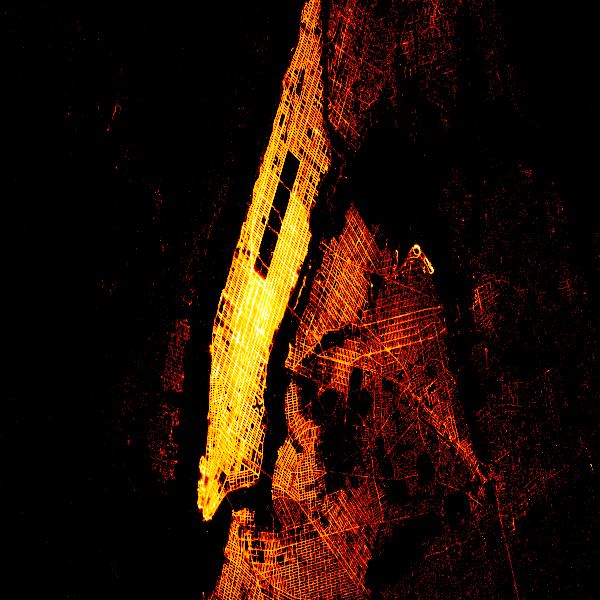

In [8]:
%%time
# lay out the canvas
agg = ds.Canvas().points(gdf, 'dropoff_x', 'dropoff_y')
# shade in the picture 
tf.set_background(tf.shade(agg, cmap=fire), "black")

In [9]:
then = time.time()
total_time = then - now
# what was our total runtime?
print(f'{int(total_time//60)} min {int(total_time%60)} sec\nTOTAL TIME: {total_time}')

9 min 2 sec
TOTAL TIME: 542.3889544010162


# EXTRA
The below is optional and is meant to test the capacity of a 16GB Tesla T4 GPU (or whatever you have) when processing this much data.

In [1]:
%%time
import datashader as ds
from colorcet import fire, rainbow
from datashader import transfer_functions as tf
from blazingsql import BlazingContext
# connect to BlazingSQL
bc = BlazingContext()

BlazingContext ready
CPU times: user 11.4 s, sys: 1.1 s, total: 12.5 s
Wall time: 16.1 s


In [2]:
# list of direct paths for all months (jan - aug was most I was able to process)
paths = [f'/home/jupyter-winston/turbo-telegram/data/taxi_0{i}.csv' if i < 10 
         else f'/home/jupyter-winston/turbo-telegram/data/taxi_{i}.csv' for i in range(1, 9)]

In [3]:
%%time
# make table from all 12 (8*) months at once
bc.create_table('big_taxi', paths, header=0)

CPU times: user 9.59 ms, sys: 547 µs, total: 10.1 ms
Wall time: 22.7 ms


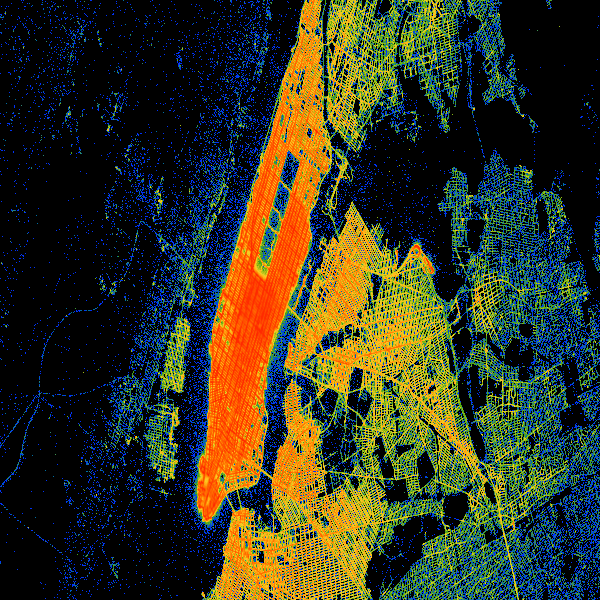

In [4]:
# visualize dropoff points 
agg = ds.Canvas().points(bc.sql('select dropoff_x, dropoff_y from big_taxi'), 'dropoff_x', 'dropoff_y')
# shade in & display picture
tf.set_background(tf.shade(agg, cmap=rainbow), "black")